In [1]:
import os
from prefect import task, Flow
import qcodes as qc
import nanotune as nt

nt.new_database('prefect_demo.db', os.getcwd())
qc.new_experiment('prefect_demo', 'no_sample')

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210528-79433-qcodes.log


prefect_demo#no_sample#13@/Users/jana/Documents/code/nanotune/nanotune/docs/examples/prefect_demo.db
----------------------------------------------------------------------------------------------------

In [2]:
%run load_station.py

C01R01_gate step 0.0005
C01R01_gate inter_delay 0.00125


In [3]:
%run train_classifier.py

/Users/jana/Documents/code/nanotune/nanotune/data/training_data/pinchoff.npy
n_samples: 3699


In [4]:
from typing import Tuple

from nanotune.tuningstages.base_tasks import (
    SetpointSettingsDict,
    DataSettingsDict,
    ReadoutMethodsDict,
    compute_linear_setpoints,
    swap_range_limits_if_needed,
    get_current_voltages,
    take_data_add_metadata,
    set_up_gates_for_measurement,
    prepare_metadata,
    get_extracted_features,
    check_measurement_quality,
    save_extracted_features,
    save_machine_learning_result,
)

from nanotune.tuningstages.take_data import ramp_to_setpoint
from nanotune.fit.pinchofffit import PinchoffFit

In [5]:
mux.drive(True)

In [6]:
@task
def create_settings() -> Tuple[SetpointSettingsDict, ReadoutMethodsDict, DataSettingsDict]:
    setpoint_settings = SetpointSettingsDict(
        parameters_to_sweep=[chip.C01R01.gate], # gates to sweep (only 1D or 2D)
        current_valid_ranges=[(-2.0, 0.0)], # expected range of pinch-off
        safety_voltage_ranges=[(-3.0, 0.0)], # maximum voltages allowed
        voltage_precision=0.01 # sweep step size
    )

    readout_methods = ReadoutMethodsDict(
        dc_current = chip.C01R01.drain, # transport through the device
        #dc_sensor = chip.C01R01.drain, # optional extra current sensing
        rf = mux.readout # RF readout
    )

    data_settings = DataSettingsDict(
        db_name="prefect_demo",
        db_folder=os.getcwd(),
        normalization_constants={
            "dc_current": (-4.408e-07, 0.0024),
            "rf": (0.002004, 0.00838),
        },
        segment_size=1,
    )

    return (
        setpoint_settings,
        readout_methods,
        data_settings
    )

In [7]:
@task
def compute_setpoints(setpoint_settings):
    initial_voltages = get_current_voltages(
        setpoint_settings["parameters_to_sweep"]
    )

    current_valid_ranges = swap_range_limits_if_needed(
        initial_voltages,
        setpoint_settings["current_valid_ranges"]
    )

    setpoints = compute_linear_setpoints(
        current_valid_ranges,
        setpoint_settings["voltage_precision"],
    )
    return setpoints

In [8]:
@task
def measure(setpoints, setpoint_settings, data_settings, readout_methods):
    example_param = setpoint_settings["parameters_to_sweep"][0]
    device_name = example_param.name_parts[0]
    nt_meta = prepare_metadata(
        chip.C01R01.name,
        data_settings["normalization_constants"],
        readout_methods,
    )
    dc_sensor = readout_methods.get("dc_sensor")
    rf = readout_methods.get("rf")

    def finish_early(current_output_dict):
        if dc_sensor is not None:
            dc_value = current_output_dict[str(dc_sensor)]
        dc_value = 0.0
        rf_value = current_output_dict[str(rf)]
        return dc_value < 0.0001 and rf_value < 0.0001

    run_id = take_data_add_metadata(
        setpoint_settings["parameters_to_sweep"],
        list(readout_methods.values()),  # type: ignore
        setpoints,
        finish_early_check=finish_early,
        do_at_inner_setpoint=ramp_to_setpoint,
        pre_measurement_metadata=nt_meta,
    )

    return run_id

In [9]:
@task
def plot(run_id, setpoint_settings, readout_methods):
    ds = qc.load_by_id(run_id)
    gate = setpoint_settings["parameters_to_sweep"][0]
    dc_sensor = readout_methods.get("dc_sensor")
    rf = readout_methods.get("rf")
    df_dict = ds.to_pandas_dataframe_dict()
    if dc_sensor is not None:
        return [df_dict[str(dc_sensor)].plot(), df_dict[str(rf)].plot()]
    return df_dict[str(rf)].plot()

In [10]:
@task
def extract_features(run_id, data_settings):
    ml_result: Dict[str, Any] = {}
    ml_result["features"] = get_extracted_features(
        PinchoffFit,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    ml_result["quality"] = check_measurement_quality(
        classifier,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    ml_result["regime"] = "pinchoff"
    return ml_result

In [11]:
@task
def save_features(run_id, ml_result, data_settings):
    save_extracted_features(
        PinchoffFit,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    save_machine_learning_result(run_id, ml_result)

In [12]:
@task
def verify_result(ml_result):
    return bool(ml_result["quality"])

In [13]:
with Flow("Pinch-off") as flow:
    (setpoint_settings, readout_methods, data_settings) = create_settings()
    setpoints = compute_setpoints(setpoint_settings)
    run_id = measure(setpoints, setpoint_settings, data_settings, readout_methods)
    figs = plot(run_id, setpoint_settings, readout_methods)
    features = extract_features(run_id, data_settings)
    save_features(run_id, features, data_settings)
    success = verify_result(features)

[2021-05-28 13:13:57+0200] INFO - prefect.FlowRunner | Beginning Flow run for 'Pinch-off'
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings': Starting task run...
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings': Finished task run for task with final state: 'Success'
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[1]': Starting task run...
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[1]': Finished task run for task with final state: 'Success'
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[2]': Starting task run...
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[2]': Finished task run for task with final state: 'Success'
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[0]': Starting task run...
[2021-05-28 13:13:57+0200] INFO - prefect.TaskRunner | Task 'create_settings[0]': Finished ta

2021-05-28 13:14:10,017 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 245 ¦ ('Dataset 13: ', 'Wrong normalization constant')
2021-05-28 13:14:10,091 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 245 ¦ ('Dataset 13: ', 'Wrong normalization constant')


[2021-05-28 13:14:10+0200] INFO - prefect.TaskRunner | Task 'extract_features': Finished task run for task with final state: 'Success'
[2021-05-28 13:14:10+0200] INFO - prefect.TaskRunner | Task 'save_features': Starting task run...


2021-05-28 13:14:10,171 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 245 ¦ ('Dataset 13: ', 'Wrong normalization constant')


[2021-05-28 13:14:10+0200] INFO - prefect.TaskRunner | Task 'save_features': Finished task run for task with final state: 'Success'
[2021-05-28 13:14:10+0200] INFO - prefect.TaskRunner | Task 'verify_result': Starting task run...
[2021-05-28 13:14:10+0200] INFO - prefect.TaskRunner | Task 'verify_result': Finished task run for task with final state: 'Success'
[2021-05-28 13:14:10+0200] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


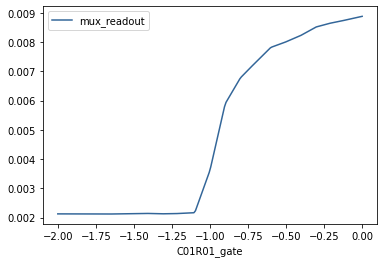

In [14]:
state = flow.run()

In [15]:
state

<Success: "All reference tasks succeeded.">

In [16]:
ml_result = extract_features.run(state.result[run_id].result, _data_settings)
ml_result

NameError: name '_data_settings' is not defined